# Diseño Experimental IV

Las metodologías de diseño experimental ayudan a:
- Eliminar la mayor cantidad de **variación natural** posible
- Prevenir que la variabilidad no removida confundiera o **sesgara** los resultados
- Detectar causa y efectos con la **mínima cantidad de esfuerzo experimental**



Para abrir en Google Colab: <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Clases/Clases/Clase18_DisenoExperimentalIV.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
# Requerimientos
!pip install seaborn -q # Para visualización y datasets
!pip install scipy -q # Para analísis estadísticos
!pip install numpy -q # Para cálculos científicos
!pip install pandas -q # Para almacenamiento y trabajo con datos
!pip install matplotlib -q # Para visualización
!pip install statsmodels -q # Para analísis estadísticos
!pip install rdatasets -q # datasets de R
!pip install scikit-learn -q # Análisis relacionados a Machine Learning
!pip install pingouin -q # Análisis estadísticos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.7 MB/s eta 0:00:00


# Diseño en bloques aleatorizado (RCB)

Este tipo de diseño permite minimizar el efecto de la variabilidad cuando se asocia con unidades discretas.

El objetivo de este es:
1. Eliminar la mayor cantidad de variación natural del sistema
2. Aumentar la sensibilidad de los experimentos

## Caso de estudio Efecto de la droga D-anfetamina en ratas deshidratadas

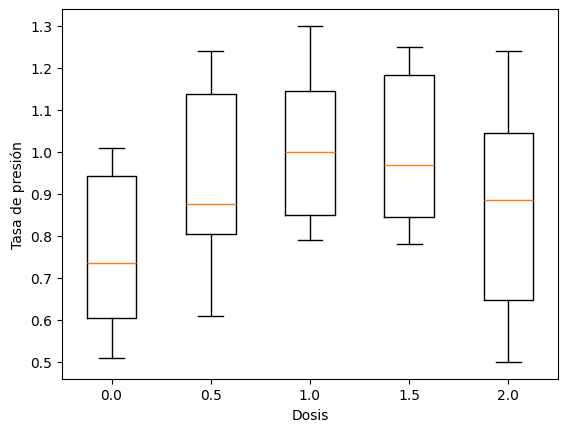

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import seaborn as sns
# Set de datos
Rata = [
    1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,10,10,10,10,10
]
dosis = [
    0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2,0,0.5,1,1.5,2
]

rate = [
    0.6,0.8,0.82,0.81,0.5,0.51,0.61,0.79,0.78,0.77,0.62,0.82,0.83,0.8,0.52,0.6,0.95,0.91,0.95,0.7,0.92,0.82,1.04,1.13,1.03,0.63,0.93,1.02,0.96,0.63,0.84,0.74,0.98,0.98,1,0.96,1.24,1.27,1.2,1.06,1.01,1.23,1.3,1.25,1.24,0.95,1.2,1.18,1.23,1.05
]

df_drug = pd.DataFrame()
df_drug['Rata'] = Rata
df_drug['dosis'] = dosis
df_drug['tasa'] = rate

# Análisis exploratorio
fig, ax = plt.subplots()

for it, dose in enumerate(df_drug['dosis'].unique()):
    df_aux = df_drug[df_drug['dosis'] == dose]
    ax.boxplot(df_aux['tasa'], positions = [it], widths = .5)

ax.set_xticklabels(df_drug['dosis'].unique())
ax.set_xlabel('Dosis')
ax.set_ylabel('Tasa de presión')
plt.show()




In [14]:
# Análisis ANOVA
from patsy.contrasts import Sum
# Normalidad de los datos
for dos in df_drug['dosis'].unique():
    df_aux = df_drug[df_drug['dosis'] == dos]
    print(f'Shapiro-Wilk Test {dos}: {st.shapiro(df_aux["tasa"]).pvalue:.4f}')

## dado a que todas distribuyen normal, podemos realizar un análsis anova
# Análizamos el efecto de la dosis sin contar a las ratas como fuente de variabilidad
model_drug = ols('tasa ~ C(dosis)', data = df_drug).fit()
anova_table_drug = sm.stats.anova_lm(model_drug, typ = "II")
print('\nOne-Way ANOVA')
print(anova_table_drug)

Shapiro-Wilk Test 0.0: 0.0794
Shapiro-Wilk Test 0.5: 0.2238
Shapiro-Wilk Test 1.0: 0.3522
Shapiro-Wilk Test 1.5: 0.1767
Shapiro-Wilk Test 2.0: 0.3391

One-Way ANOVA
            sum_sq    df         F    PR(>F)
C(dosis)  0.460208   4.0  2.629413  0.046642
Residual  1.969010  45.0       NaN       NaN


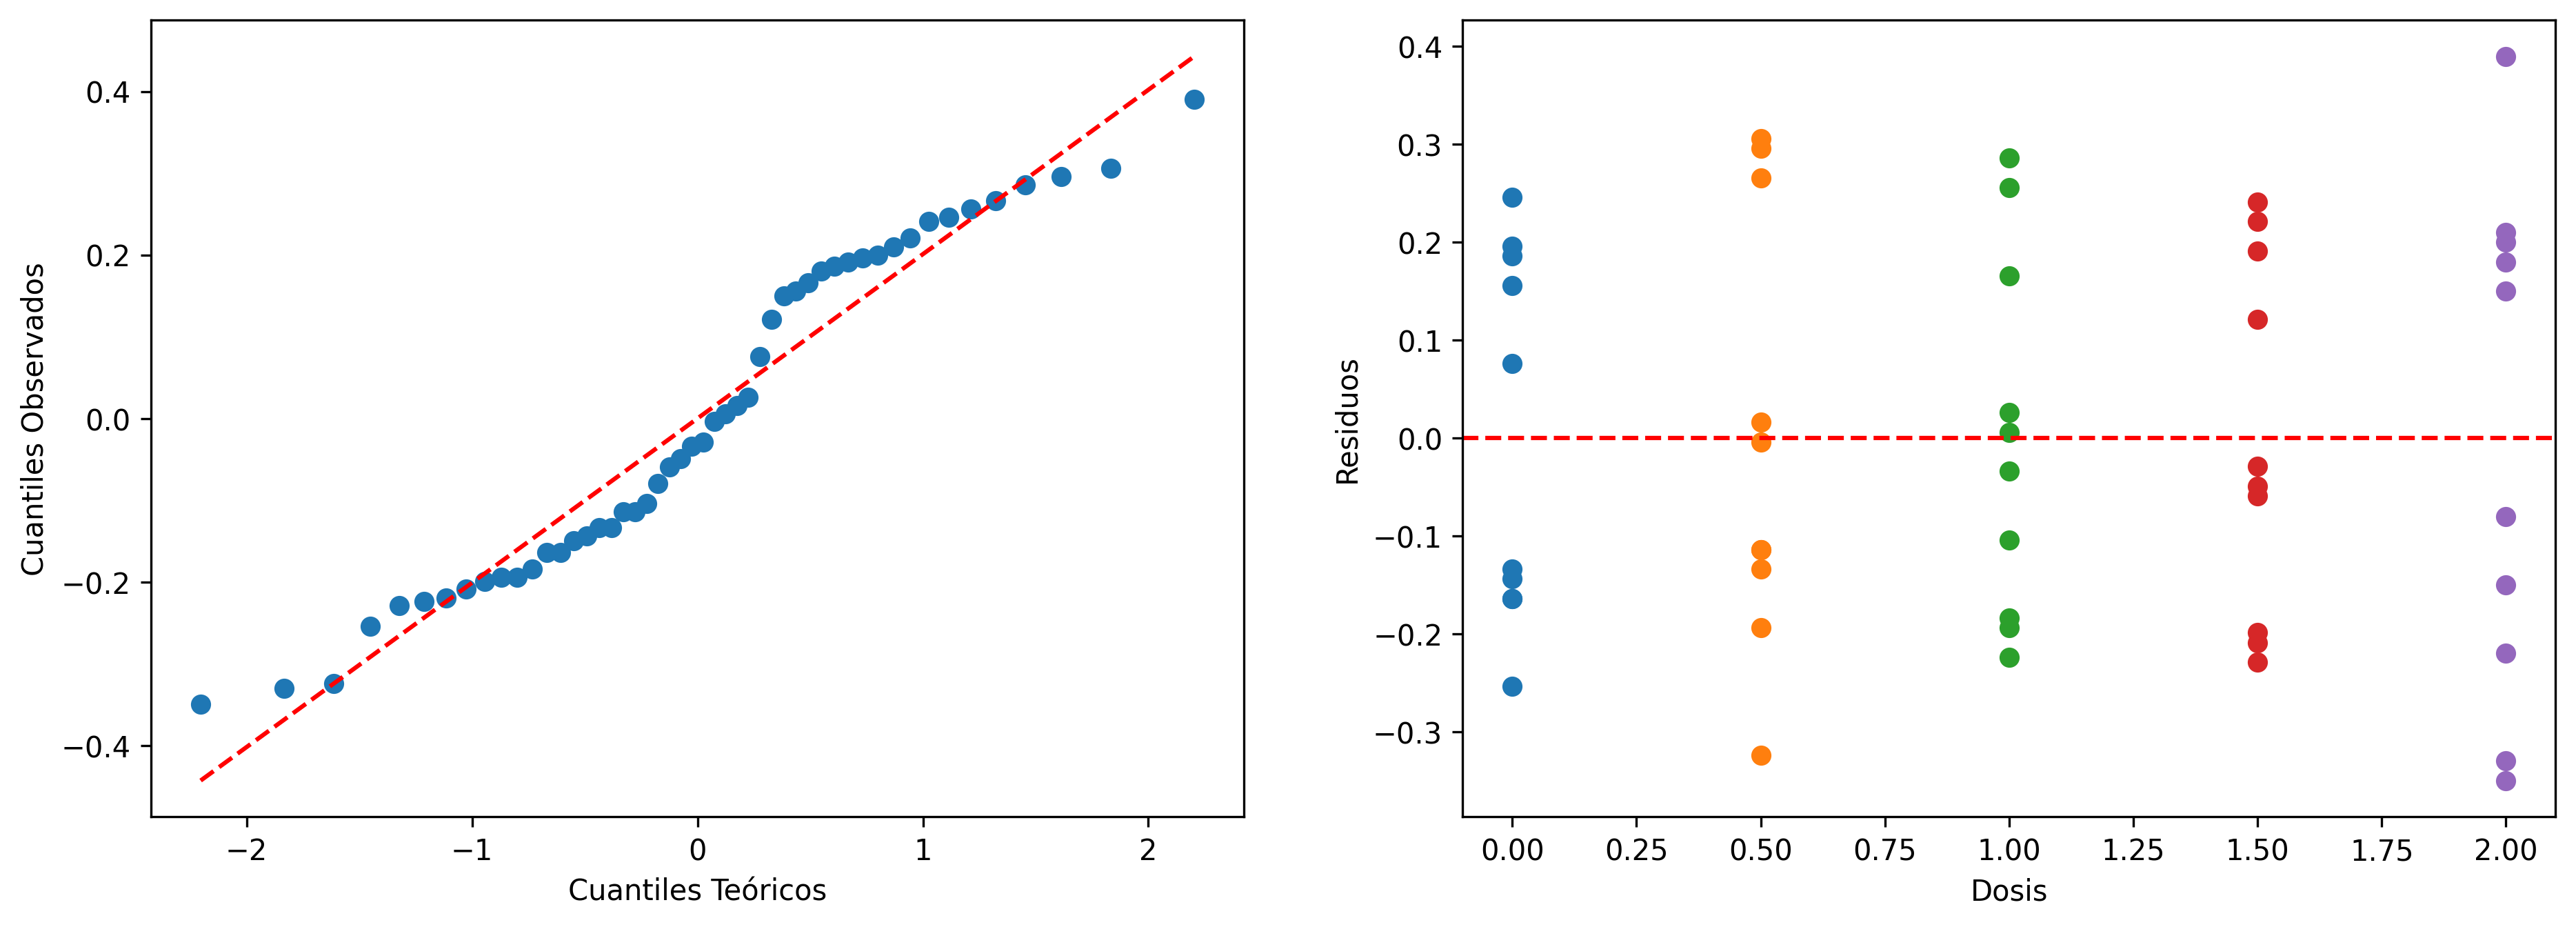

Shapiro-Wilk test de residuos
Shapiro-Wilk Test: 0.0195
Breusch-Pagan Test de residuos
Breusch-Pagan Test: 0.2325
Kruskal-Wallis Test entre grupos
Kruskal-Wallis Test: 0.1022


In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan
## Análizamos los residuos del test anova
resid = model_drug.resid

resid_df = df_drug.copy()
resid_df['resid'] = resid

fig, ax = plt.subplots(1,2, figsize = (15,5), dpi = 300)

(osm, osr) , (slope, intercept, r_val) = st.probplot(resid, fit = True)

ax[0].scatter(osm, osr)
ax[0].plot(osm, osm*slope + intercept, color = 'r', linestyle = '--')
ax[0].set_xlabel('Cuantiles Teóricos')
ax[0].set_ylabel('Cuantiles Observados')
# factors plot

for dos in resid_df['dosis'].unique():
    df_aux = resid_df[resid_df['dosis'] == dos]
    ax[1].scatter(df_aux['dosis'], df_aux['resid'])

ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('Dosis')
ax[1].set_ylabel('Residuos')
plt.show()

### Normalidad de residuos

print('Shapiro-Wilk test de residuos')
print(f'Shapiro-Wilk Test: {st.shapiro(resid).pvalue:.4f}')

### Heterocedasticidad

print('Breusch-Pagan Test de residuos')
bp_test = het_breuschpagan(model_drug.resid, model_drug.model.exog)
print(f'Breusch-Pagan Test: {bp_test[1]:.4f}')
# Realizamos un test de kurskal para analizar el efecto de la dosis
### Test kruskal - wallis

different_dosis = []
for dos in df_drug['dosis'].unique():
    df_aux = df_drug[df_drug['dosis'] == dos]
    different_dosis.append(df_aux['tasa'])
print('Kruskal-Wallis Test entre grupos')
print(f'Kruskal-Wallis Test: {st.kruskal(*different_dosis).pvalue:.4f}')


En este caso, entra la técnica de bloqueo. Si realizamos un bloqueo por rata.

In [22]:
# agregamos la rata en el análisis anova, sin contar la interacción entre dosis:rata

model_dosis_rata = ols('tasa ~ C(dosis) + C(Rata)', data = df_drug).fit()
anova_dosis_rata = sm.stats.anova_lm(model_dosis_rata)
print('Análisis de la tasa por bloques')
display(anova_dosis_rata)

model_dosis = ols('tasa ~ C(dosis)', data = df_drug).fit()
anova_dosis = sm.stats.anova_lm(model_dosis)
print('\nAnálisis de la tasa sin bloques')
display(anova_dosis)

#

Análisis de la tasa por bloques


,df,sum_sq,mean_sq,F,PR(>F)
C(dosis),4.0,0.460208,0.115052,13.780883,6.534799e-07
C(Rata),9.0,1.668458,0.185384,22.205249,3.749077e-12
Residual,36.0,0.300552,0.008349,NaN,NaN



Análisis de la tasa sin bloques


,df,sum_sq,mean_sq,F,PR(>F)
C(dosis),4.0,0.460208,0.115052,2.629413,0.046642
Residual,45.0,1.969010,0.043756,NaN,NaN


Podemos ver que si existen diferencias significativas. Ahora, podemos realizar análisis post-hoc para entender mejor.



In [150]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.libqsturng import qsturng, psturng
from itertools import combinations
from itertools import permutations


def tukey_hsd_rcbd(data, response_col, treatment_col, block_col, alpha=0.05):
    """
    Statistically valid Tukey HSD test for RCBD (Randomized Complete Block Design).

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe containing response, treatment, and block columns.
    response_col : str
        Name of the response column.
    treatment_col : str
        Name of the treatment factor column.
    block_col : str
        Name of the block factor column.
    alpha : float
        Significance level for Tukey HSD.

    Returns:
    --------
    pd.DataFrame
        Table with pairwise comparisons, mean differences, HSD, q_obs, p-values, and decision.
    """
    # Fit RCBD model: response ~ treatment + block
    model = ols(f"{response_col} ~ C({treatment_col}) + C({block_col})", data=data).fit()
    mse = model.mse_resid
    df_resid = model.df_resid

    # Compute means and number of groups
    means = data.groupby(treatment_col)[response_col].mean() # mean response of each treatment
    k = len(means) # number of treatments

    # Assume balanced design: same number of reps per treatment
    n_rep = data.groupby([treatment_col]).size().iloc[0] # get number of repetitions
    se = np.sqrt(mse / n_rep) # comparison of treatments

    # Tukey critical value
    q_crit = qsturng(1 - alpha, k, df_resid) # studentized range distribution
    hsd = q_crit * se # hsd critic

    # Pairwise comparisons
    results = []

    for i, j in combinations(means.index, 2):
        mean_diff = means[i] - means[j]
        q_obs = mean_diff / se
        pval = psturng(abs(q_obs), k, df_resid)
        reject = abs(mean_diff) > hsd
        results.append({
            'Group1': i,
            'Group2': j,
            'MeanDiff': mean_diff,
            'SE': se,
            'q_obs': q_obs,
            'HSD': hsd,
            'p-value': float(pval),
            'Reject H0': reject
        })

    return pd.DataFrame(results)

In [151]:
tukey_hsd_rcbd(
    data = df_drug,
    response_col = 'tasa',
    treatment_col = 'dosis',
    block_col = 'Rata'
)

<ipython-input-150-69d4a023bef2>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby(treatment_col)[response_col].mean() # mean response of each treatment
<ipython-input-150-69d4a023bef2>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_rep = data.groupby([treatment_col]).size().iloc[0] # get number of repetitions
<ipython-input-150-69d4a023bef2>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'p-value': float(p

,Group1,Group2,MeanDiff,SE,q_obs,HSD,p-value,Reject H0
0,0.0,0.5,-0.170,0.028894,-5.883562,0.11731,0.001666,True
1,0.0,1.0,-0.250,0.028894,-8.652298,0.11731,0.001000,True
2,0.0,1.5,-0.245,0.028894,-8.479252,0.11731,0.001000,True
3,0.0,2.0,-0.086,0.028894,-2.976390,0.11731,0.240233,False
4,0.5,1.0,-0.080,0.028894,-2.768735,0.11731,0.306816,False
5,0.5,1.5,-0.075,0.028894,-2.595689,0.11731,0.370665,False
6,0.5,2.0,0.084,0.028894,2.907172,0.11731,0.261300,False
7,1.0,1.5,0.005,0.028894,0.173046,0.11731,0.900000,False
8,1.0,2.0,0.164,0.028894,5.675907,0.11731,0.002534,True
9,1.5,2.0,0.159,0.028894,5.502861,0.11731,0.003573,True


Con esto, podemos analizar los residuos del modelo.

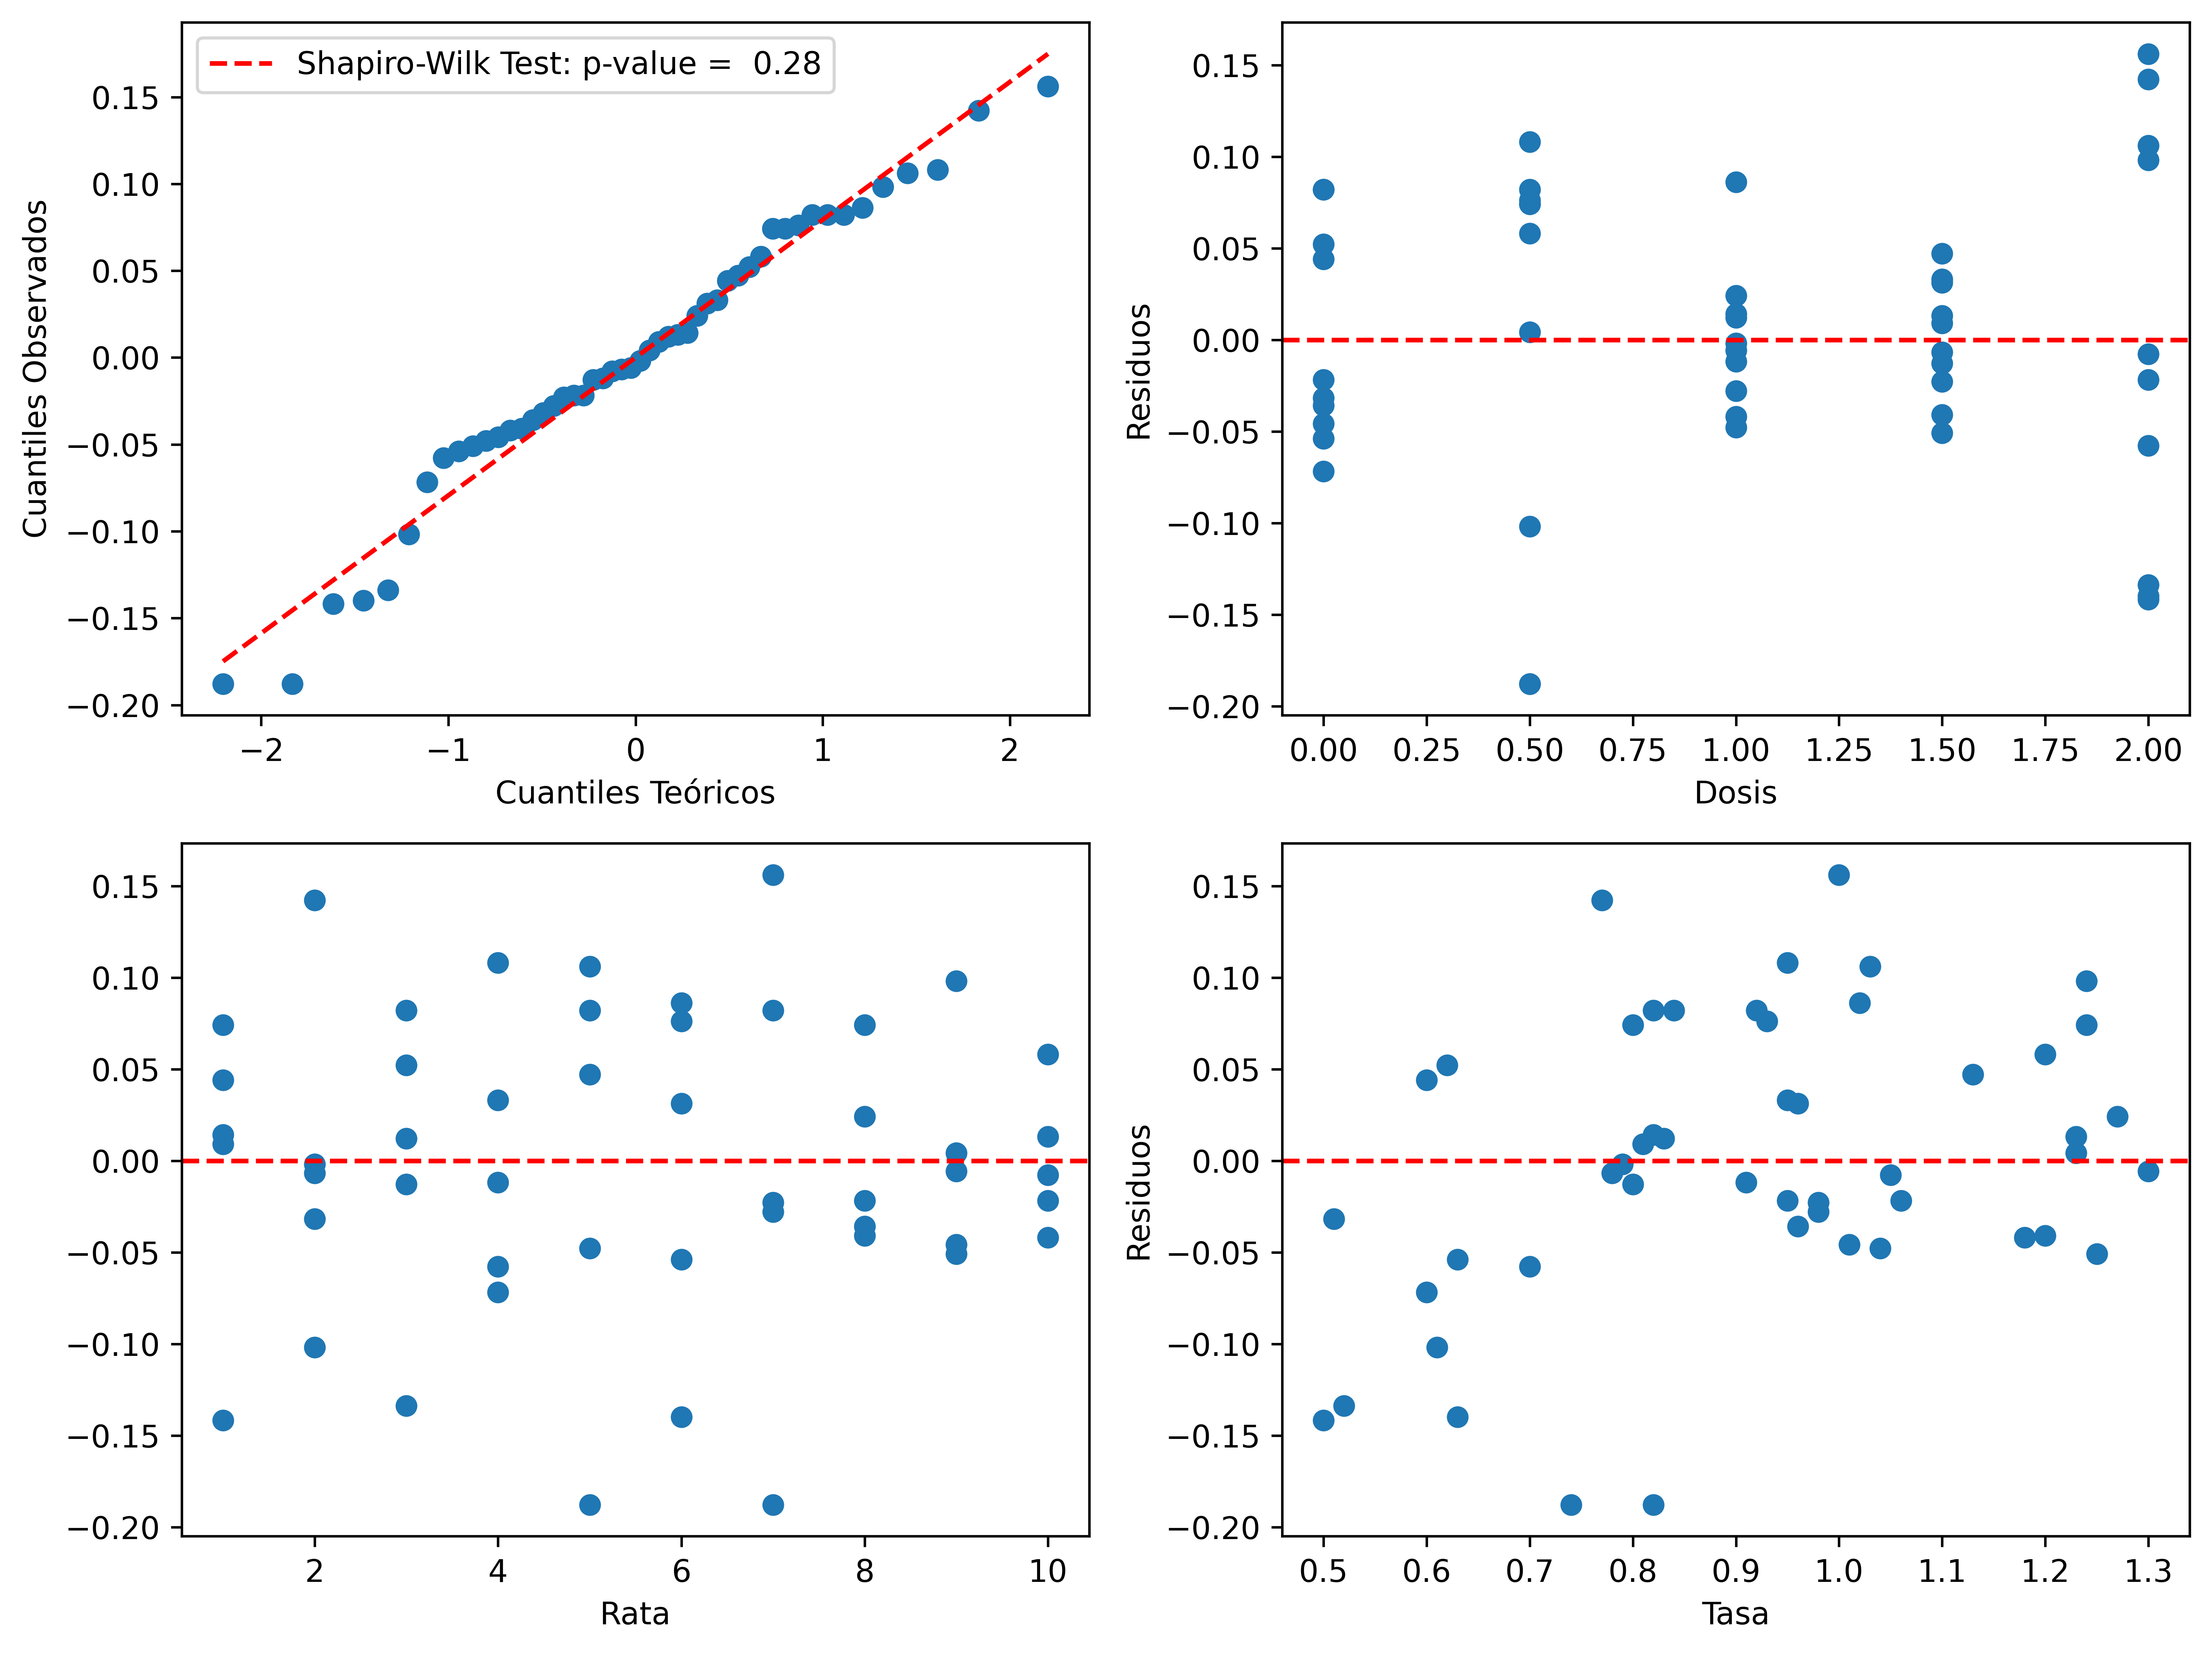

Shapiro-Wilk test de residuos
Shapiro-Wilk Test: 0.2823


In [160]:
fig, ax = plt.subplots(2,2, figsize = (10,7.5), dpi = 600)
resid_df = df_drug.copy()
resid_df['resid'] = model_dosis_rata.resid
(osm, osr) , (slope, intercept, r_val) = st.probplot(model_dosis_rata.resid, fit = True)
shapiro_p = st.shapiro(model_dosis_rata.resid).pvalue
ax[0,0].scatter(osm, osr)
ax[0,0].plot(osm, osm*slope + intercept, color = 'r', linestyle = '--',
             label = f'Shapiro-Wilk Test: p-value = {shapiro_p : .2f}')
ax[0,0].set_xlabel('Cuantiles Teóricos')
ax[0,0].set_ylabel('Cuantiles Observados')
ax[0,0].legend()
ax[0,1].scatter(
    resid_df['dosis'],
    resid_df['resid']
)
ax[0,1].axhline(y = 0, color = 'r', linestyle = '--')
ax[0,1].set_xlabel('Dosis')
ax[0,1].set_ylabel('Residuos')

ax[1,0].scatter(
    resid_df['Rata'],
    resid_df['resid']
)
ax[1,0].axhline(y = 0, color = 'r', linestyle = '--')
ax[1,0].set_xlabel('Rata')

ax[1,1].scatter(
    resid_df['tasa'],
    resid_df['resid'],
)
ax[1,1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1,1].set_xlabel('Tasa')
ax[1,1].set_ylabel('Residuos')
fig.tight_layout()
plt.show()

# Test estadisticos

print('Shapiro-Wilk test de residuos')
print(f'Shapiro-Wilk Test: {st.shapiro(model_dosis_rata.resid).pvalue:.4f}')


In [161]:
## Análisis BoxCox
tasa_boxcox, lambda_box = st.boxcox(df_drug['tasa'])
print(f'Lambda Óptimo: {lambda_box:.4f}')
df_drug['tasa_boxcox'] = tasa_boxcox

model_drug_rat_boxcox = ols('tasa_boxcox ~ C(dosis) + C(Rata)', data = df_drug).fit()
anova_drug_rat_boxcox = sm.stats.anova_lm(model_drug_rat_boxcox)
print('\nTwo-Way ANOVA con BoxCox')
print(anova_drug_rat_boxcox)

Lambda Óptimo: 0.9546

Two-Way ANOVA con BoxCox
            df    sum_sq   mean_sq          F        PR(>F)
C(dosis)   4.0  0.467023  0.116756  13.697781  6.963841e-07
C(Rata)    9.0  1.681893  0.186877  21.924388  4.522493e-12
Residual  36.0  0.306853  0.008524        NaN           NaN


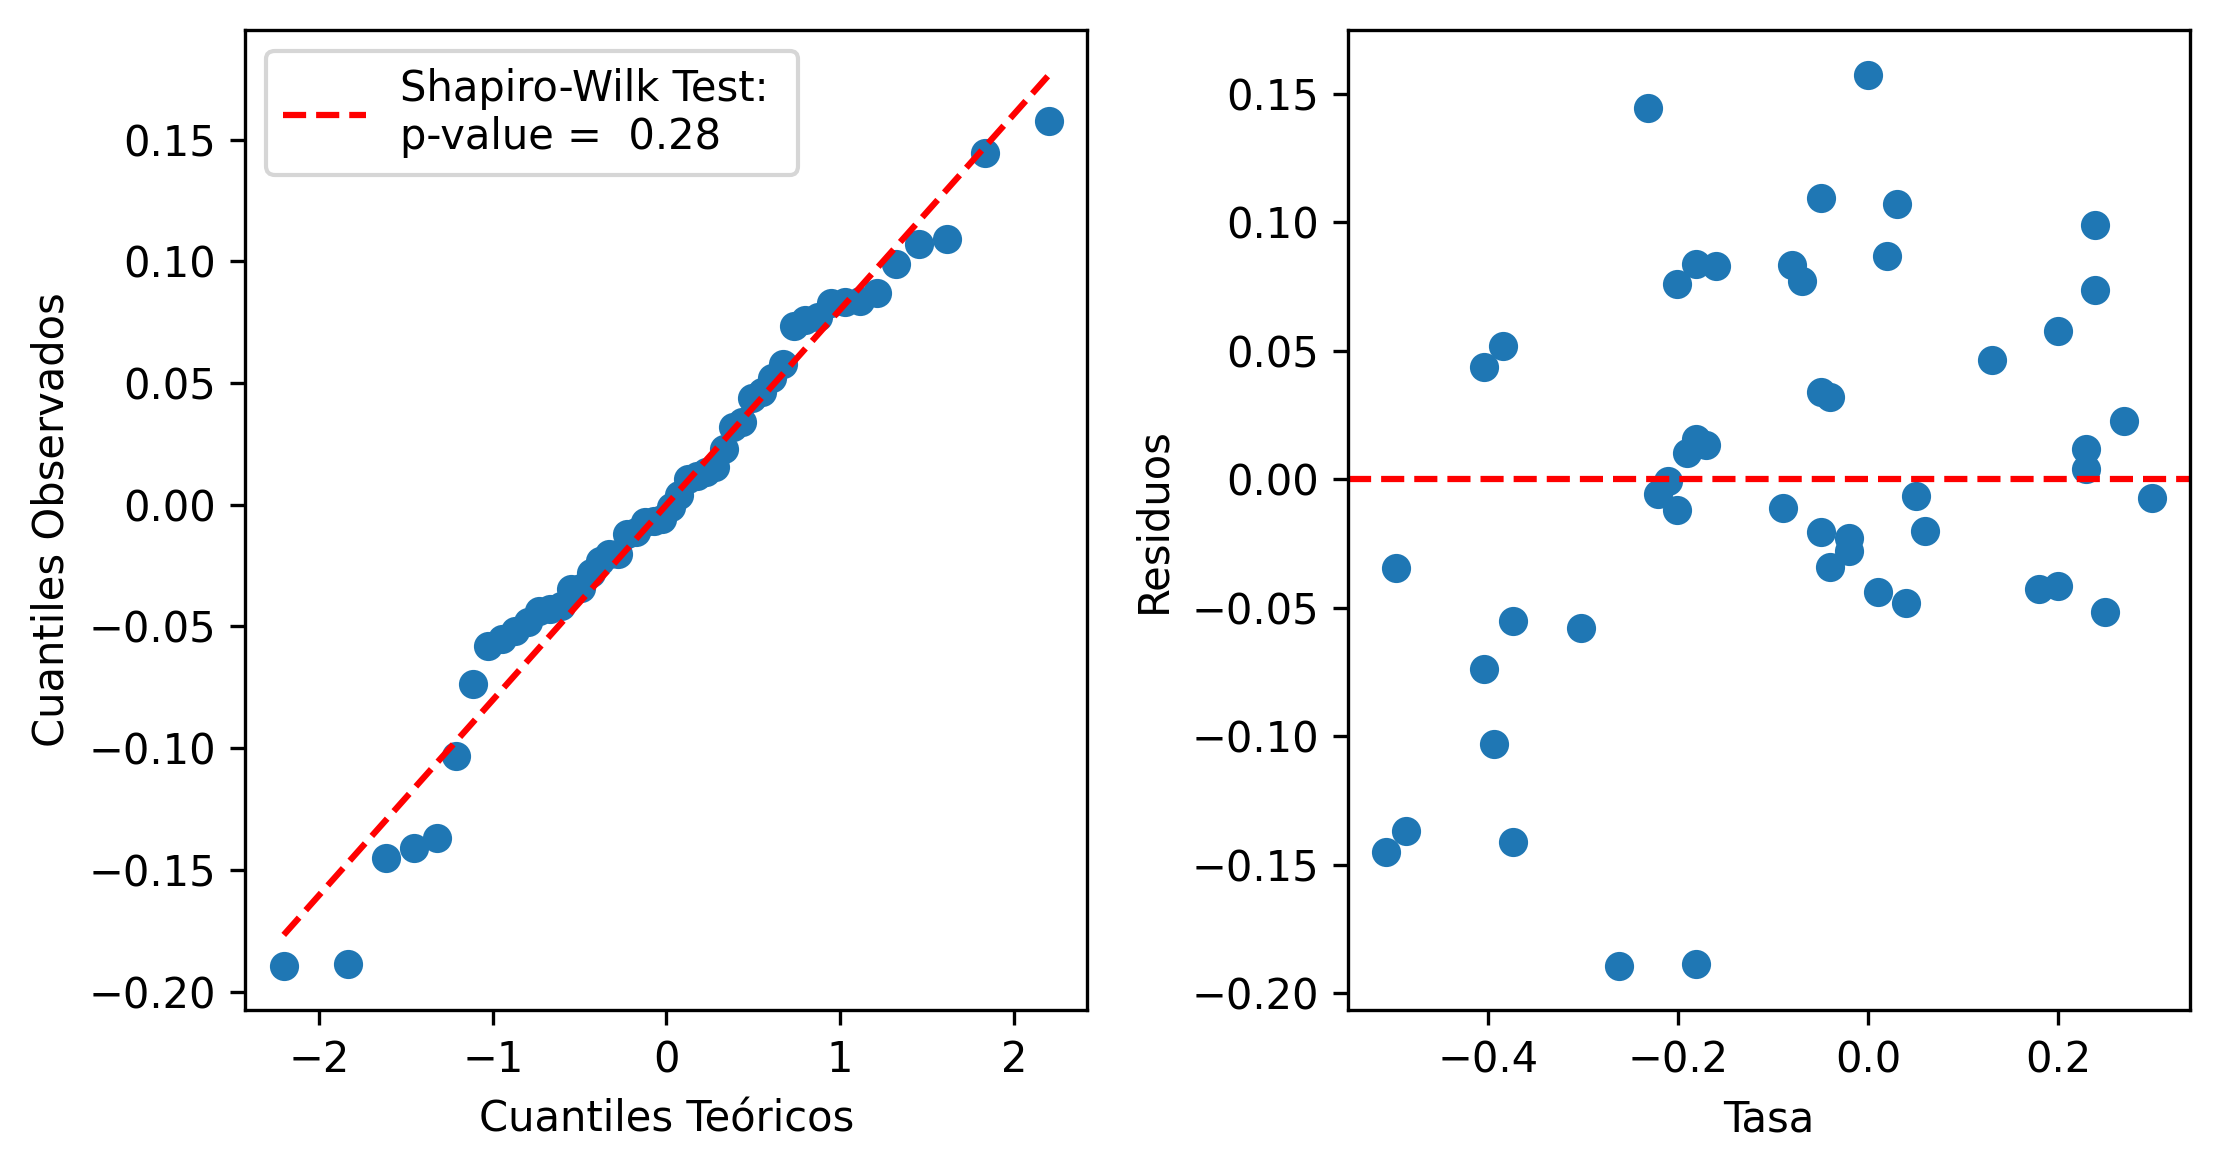

In [172]:
df_drug['resid'] = model_drug_rat_boxcox.resid
fig, ax = plt.subplots(1,2, figsize = (7.5,4), dpi = 300)
(osm, osr) , (slope, intercept, r_val) = st.probplot(model_drug_rat_boxcox.resid, fit = True)
shapiro_p = st.shapiro(model_drug_rat_boxcox.resid).pvalue
ax[0].scatter(osm, osr
              )
ax[0].plot(osm, osm*slope + intercept, color = 'r', linestyle = '--',
             label = f'Shapiro-Wilk Test: \np-value = {shapiro_p : .2f}')
ax[0].set_xlabel('Cuantiles Teóricos')
ax[0].set_ylabel('Cuantiles Observados')
ax[0].legend()
ax[1].scatter(
    df_drug['tasa_boxcox'],
    df_drug['resid']
)
ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('Tasa')
ax[1].set_ylabel('Residuos')
fig.tight_layout()
plt.show()

Es posible estimar el número de bloques necesarios en el experimento mediante el poder estadístico de la prueba.

In [186]:
alpha = 0.05
MSE = 0.00835 # MSE del diseño de con bloque
SSG = 0.4602 # Suma de cuadrados del tratamiento
n_bloques = np.arange(2, 5+1)

for b in n_bloques:
    # calculamos el poder de la prueba mediante una distribución F
    # Al igual que un anova
    nu1 = 5 - 1 # grados de libertad del tratamiento
    nu2 = (b - 1) * (5 - 1) # GL
    nc = (b * SSG) / MSE # parametro de no_centralidad


    F_crit = st.f.ppf(1 - alpha, nu1, nu2)
    power = 1 - st.ncf.cdf(F_crit, nu1, nu2, nc)

    print(f'Power para {b} bloques: {power:.4f}')

Power para 2 bloques: 0.9967
Power para 3 bloques: 1.0000
Power para 4 bloques: 1.0000
Power para 5 bloques: 1.0000


# Diseño Factorial en Bloques Completamente Aleatorizados (RCFB)

En el diseño RCFB se aplica un bloqueo para un diseño factorial, se contruye como un CRFD pero se agrega el término de bloqueo sin interacción, este permite el calculo de el término de error, pues se asume que no hay interacción con los bloques.

## Caso de Estudio: Acitivdad enzimatica en ratas tratadas con BHA

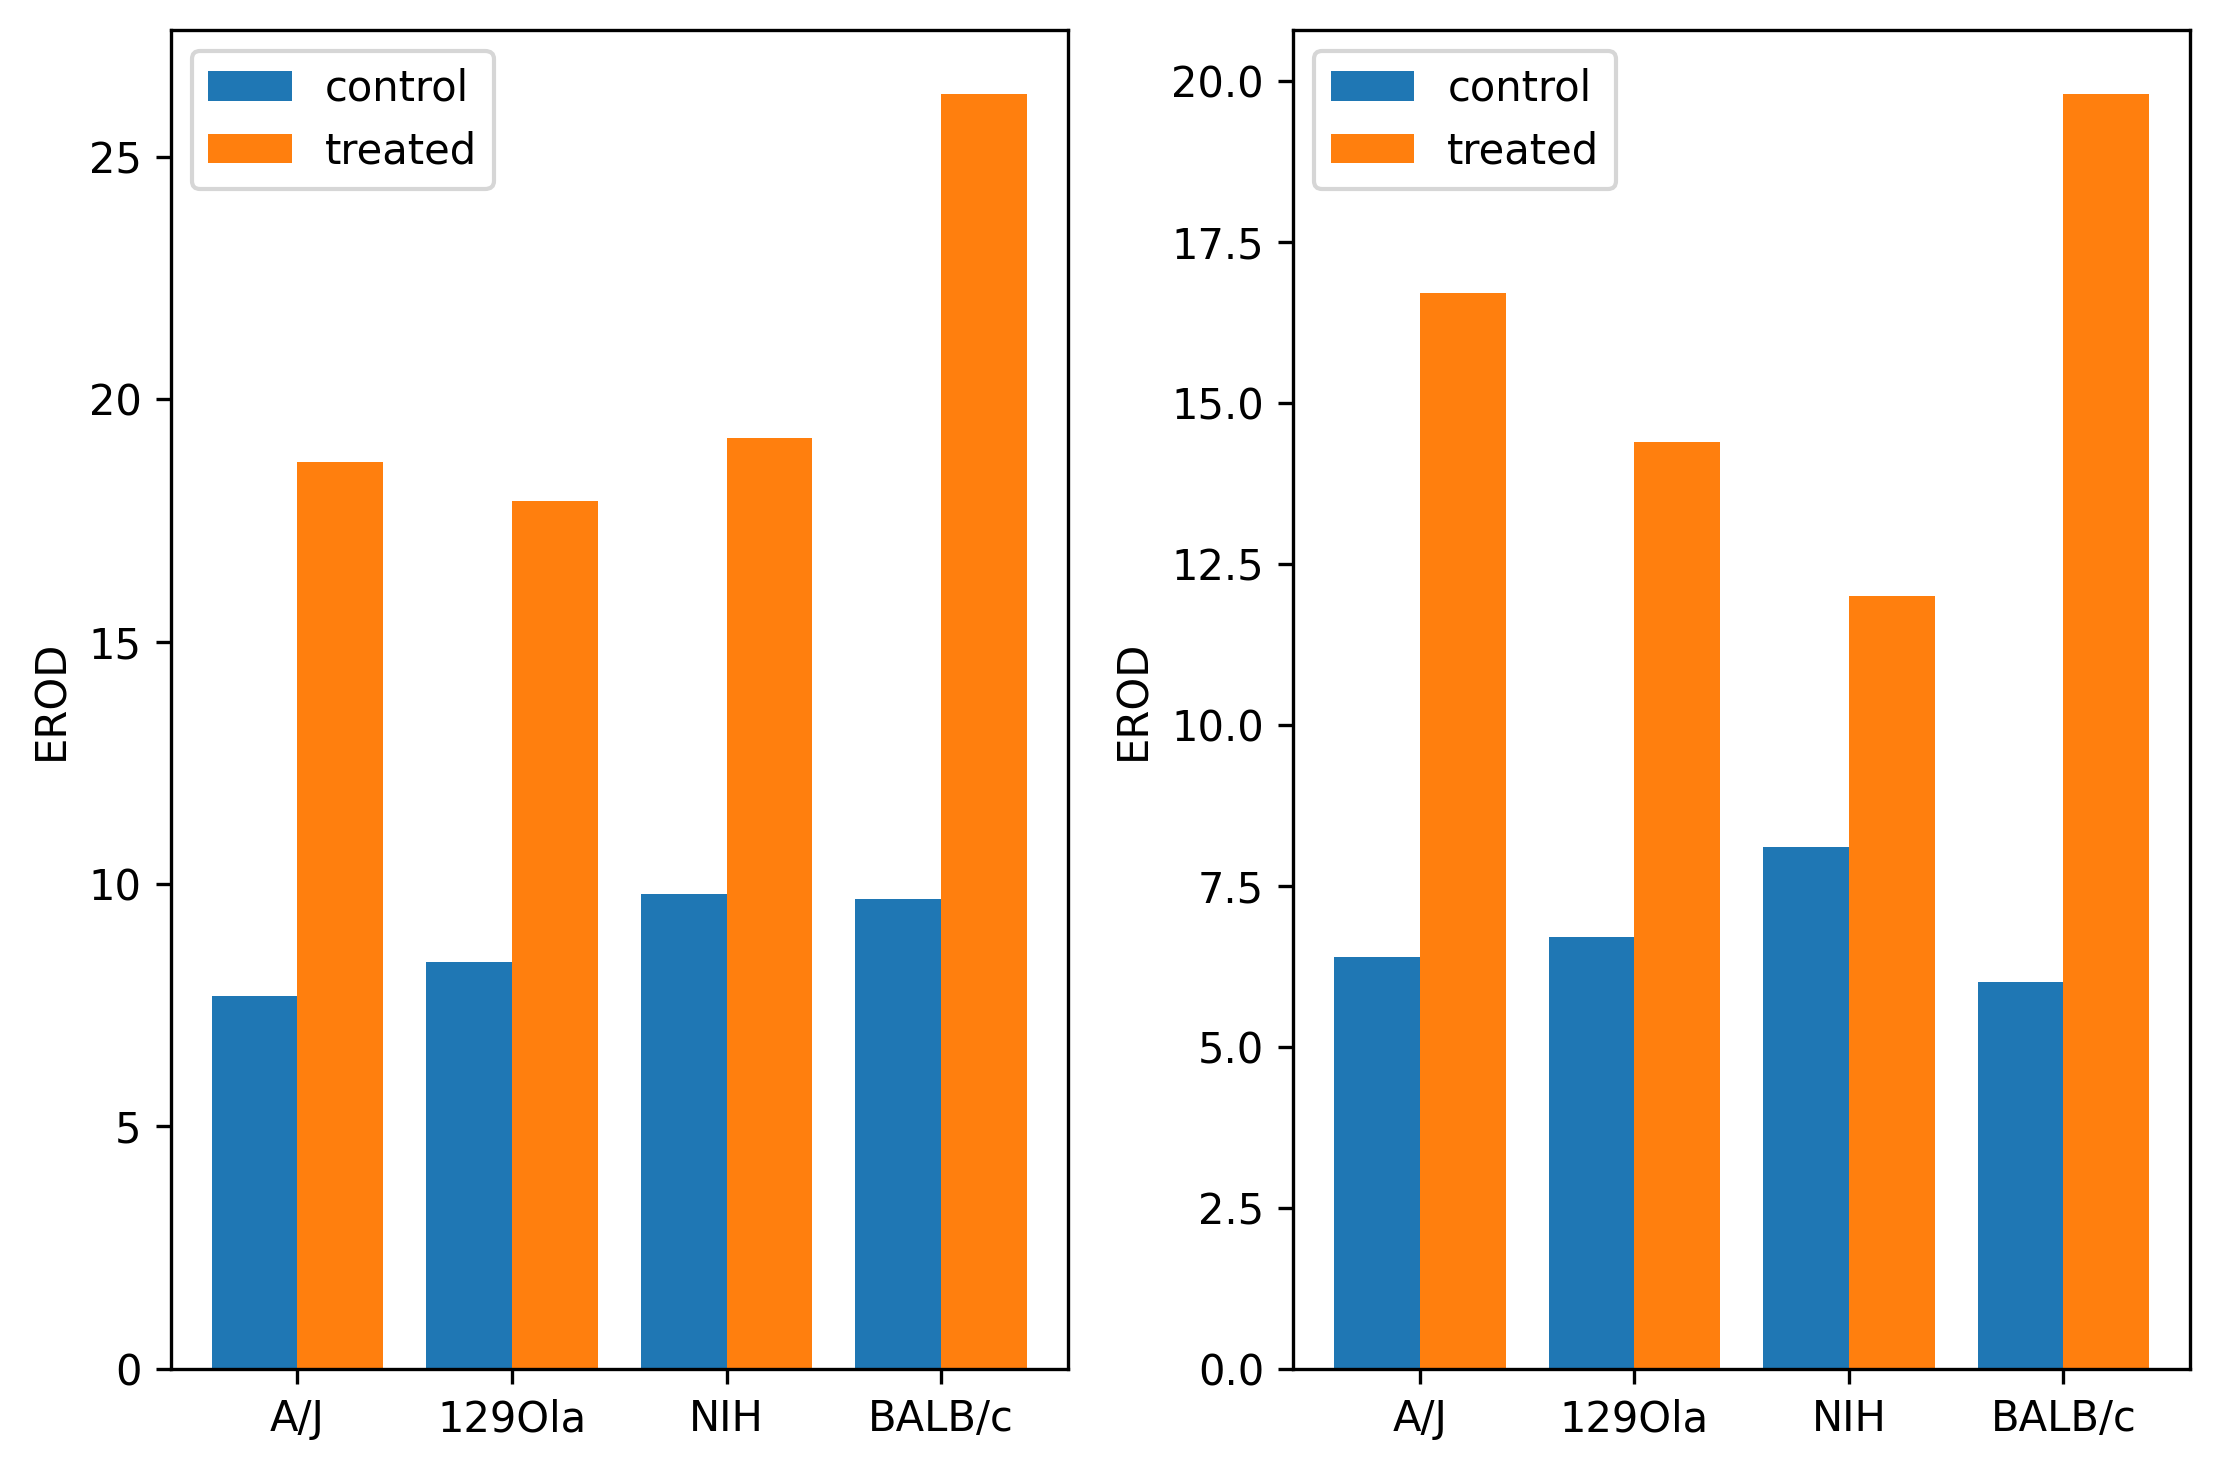

In [188]:
# Set de datos
Block = [1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2]

strain = ["A/J", "A/J", "A/J", "A/J", "129Ola", "129Ola", "129Ola", "129Ola", "NIH", "NIH", "NIH", "NIH", "BALB/c", "BALB/c", "BALB/c", "BALB/c"]

treatment = ["treated", "control", "treated", "control", "treated", "control", "treated", "control", "treated", "control", "treated", "control", "treated", "control", "treated", "control"]

EROD = [18.7, 7.7, 16.7, 6.4, 17.9, 8.4, 14.4, 6.7, 19.2, 9.8, 12, 8.1, 26.3, 9.7, 19.8, 6]

df_bha = pd.DataFrame()
df_bha['Block'] = Block
df_bha['strain'] = strain
df_bha['treatment'] = treatment
df_bha['EROD'] = EROD

# Análisis exploratorio

fig, ax = plt.subplots(1,2, figsize = (7.5,5), dpi = 300)

for bloc in df_bha['Block'].unique():
    df_aux = df_bha[df_bha['Block'] == bloc]
    control = df_aux[df_aux['treatment'] == 'control']
    treated = df_aux[df_aux['treatment'] == 'treated']
    indices = np.arange(len(control['treatment']))
    ax[bloc-1].bar(indices, control['EROD'], width = 0.4, label = 'control')
    ax[bloc-1].bar(indices + 0.4, treated['EROD'], width = 0.4, label = 'treated')

    ax[bloc-1].set_xticks(indices + 0.2)
    ax[bloc-1].set_xticklabels(control['strain'])
    ax[bloc-1].set_ylabel('EROD')
    ax[bloc-1].legend()
fig.tight_layout()
plt.show()


In [189]:
# Analisis sin bloqueo

model_bha_nobloq = ols('EROD ~ C(treatment) * C(strain)', data = df_bha).fit()
anova_bha_nobloq_anova = sm.stats.anova_lm(model_bha_nobloq)
print('\nTwo-Way ANOVA sin bloqueo')
print(anova_bha_nobloq_anova)

model_bha_bloq = ols('EROD ~ C(Block) + C(treatment) * C(strain)', data = df_bha).fit()
anova_bha_bloq_anova = sm.stats.anova_lm(model_bha_bloq)
print('\nTwo-Way ANOVA con bloqueo')
print(anova_bha_bloq_anova)


Two-Way ANOVA sin bloqueo
                         df    sum_sq    mean_sq          F    PR(>F)
C(treatment)            1.0  422.3025  422.30250  51.382814  0.000095
C(strain)               3.0   32.9625   10.98750   1.336882  0.328994
C(treatment):C(strain)  3.0   40.3425   13.44750   1.636198  0.256572
Residual                8.0   65.7500    8.21875        NaN       NaN

Two-Way ANOVA con bloqueo
                         df    sum_sq     mean_sq           F    PR(>F)
C(Block)                1.0   47.6100   47.610000   18.372106  0.003627
C(treatment)            1.0  422.3025  422.302500  162.961273  0.000004
C(strain)               3.0   32.9625   10.987500    4.239939  0.052741
C(treatment):C(strain)  3.0   40.3425   13.447500    5.189223  0.033685
Residual                7.0   18.1400    2.591429         NaN       NaN


Text(0, 0.5, 'EROD')

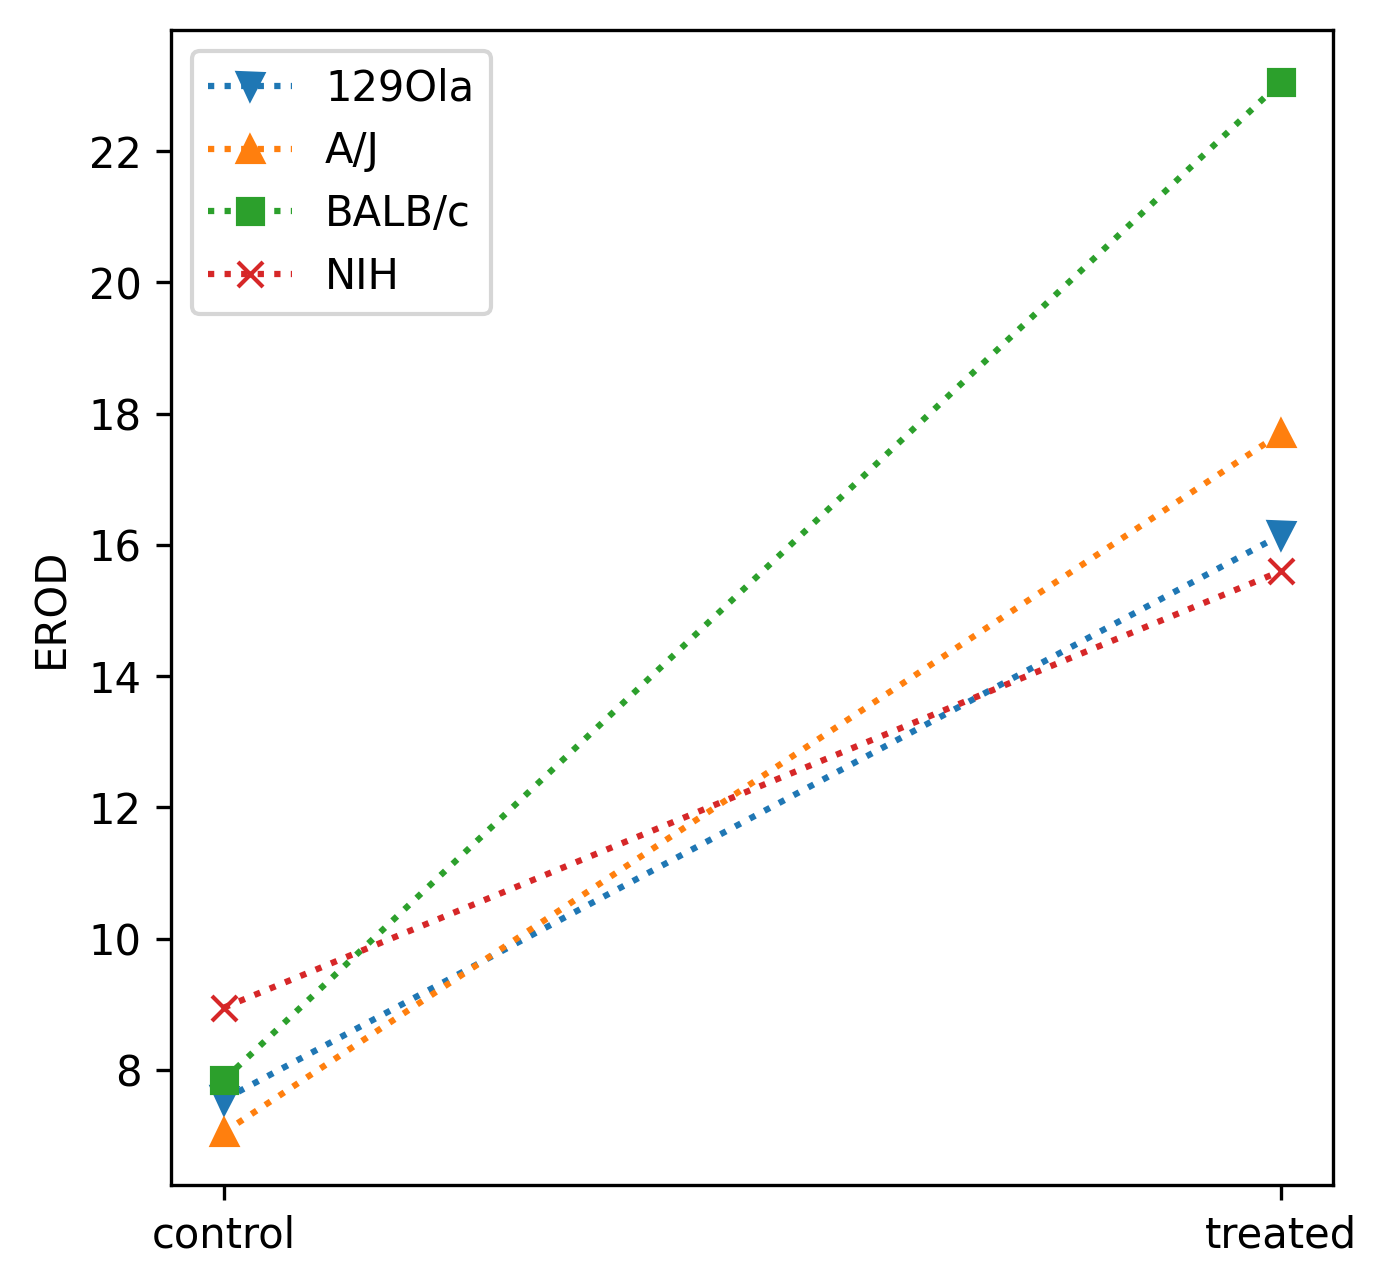

In [190]:
# Efecto de cada tratamiento

fig, ax = plt.subplots(figsize = (5,5), dpi = 300)

average_block  = df_bha.groupby(['treatment', 'strain'])['EROD'].mean().reset_index()
markers = ['v', '^', 's', 'x']
for strain, mark in zip(average_block['strain'].unique(), markers):
    df_aux = average_block[average_block['strain'] == strain]
    ax.plot(df_aux['treatment'], df_aux['EROD'], marker = mark, label = strain, linestyle = ':')
    ax.legend()


ax.set_ylabel('EROD')


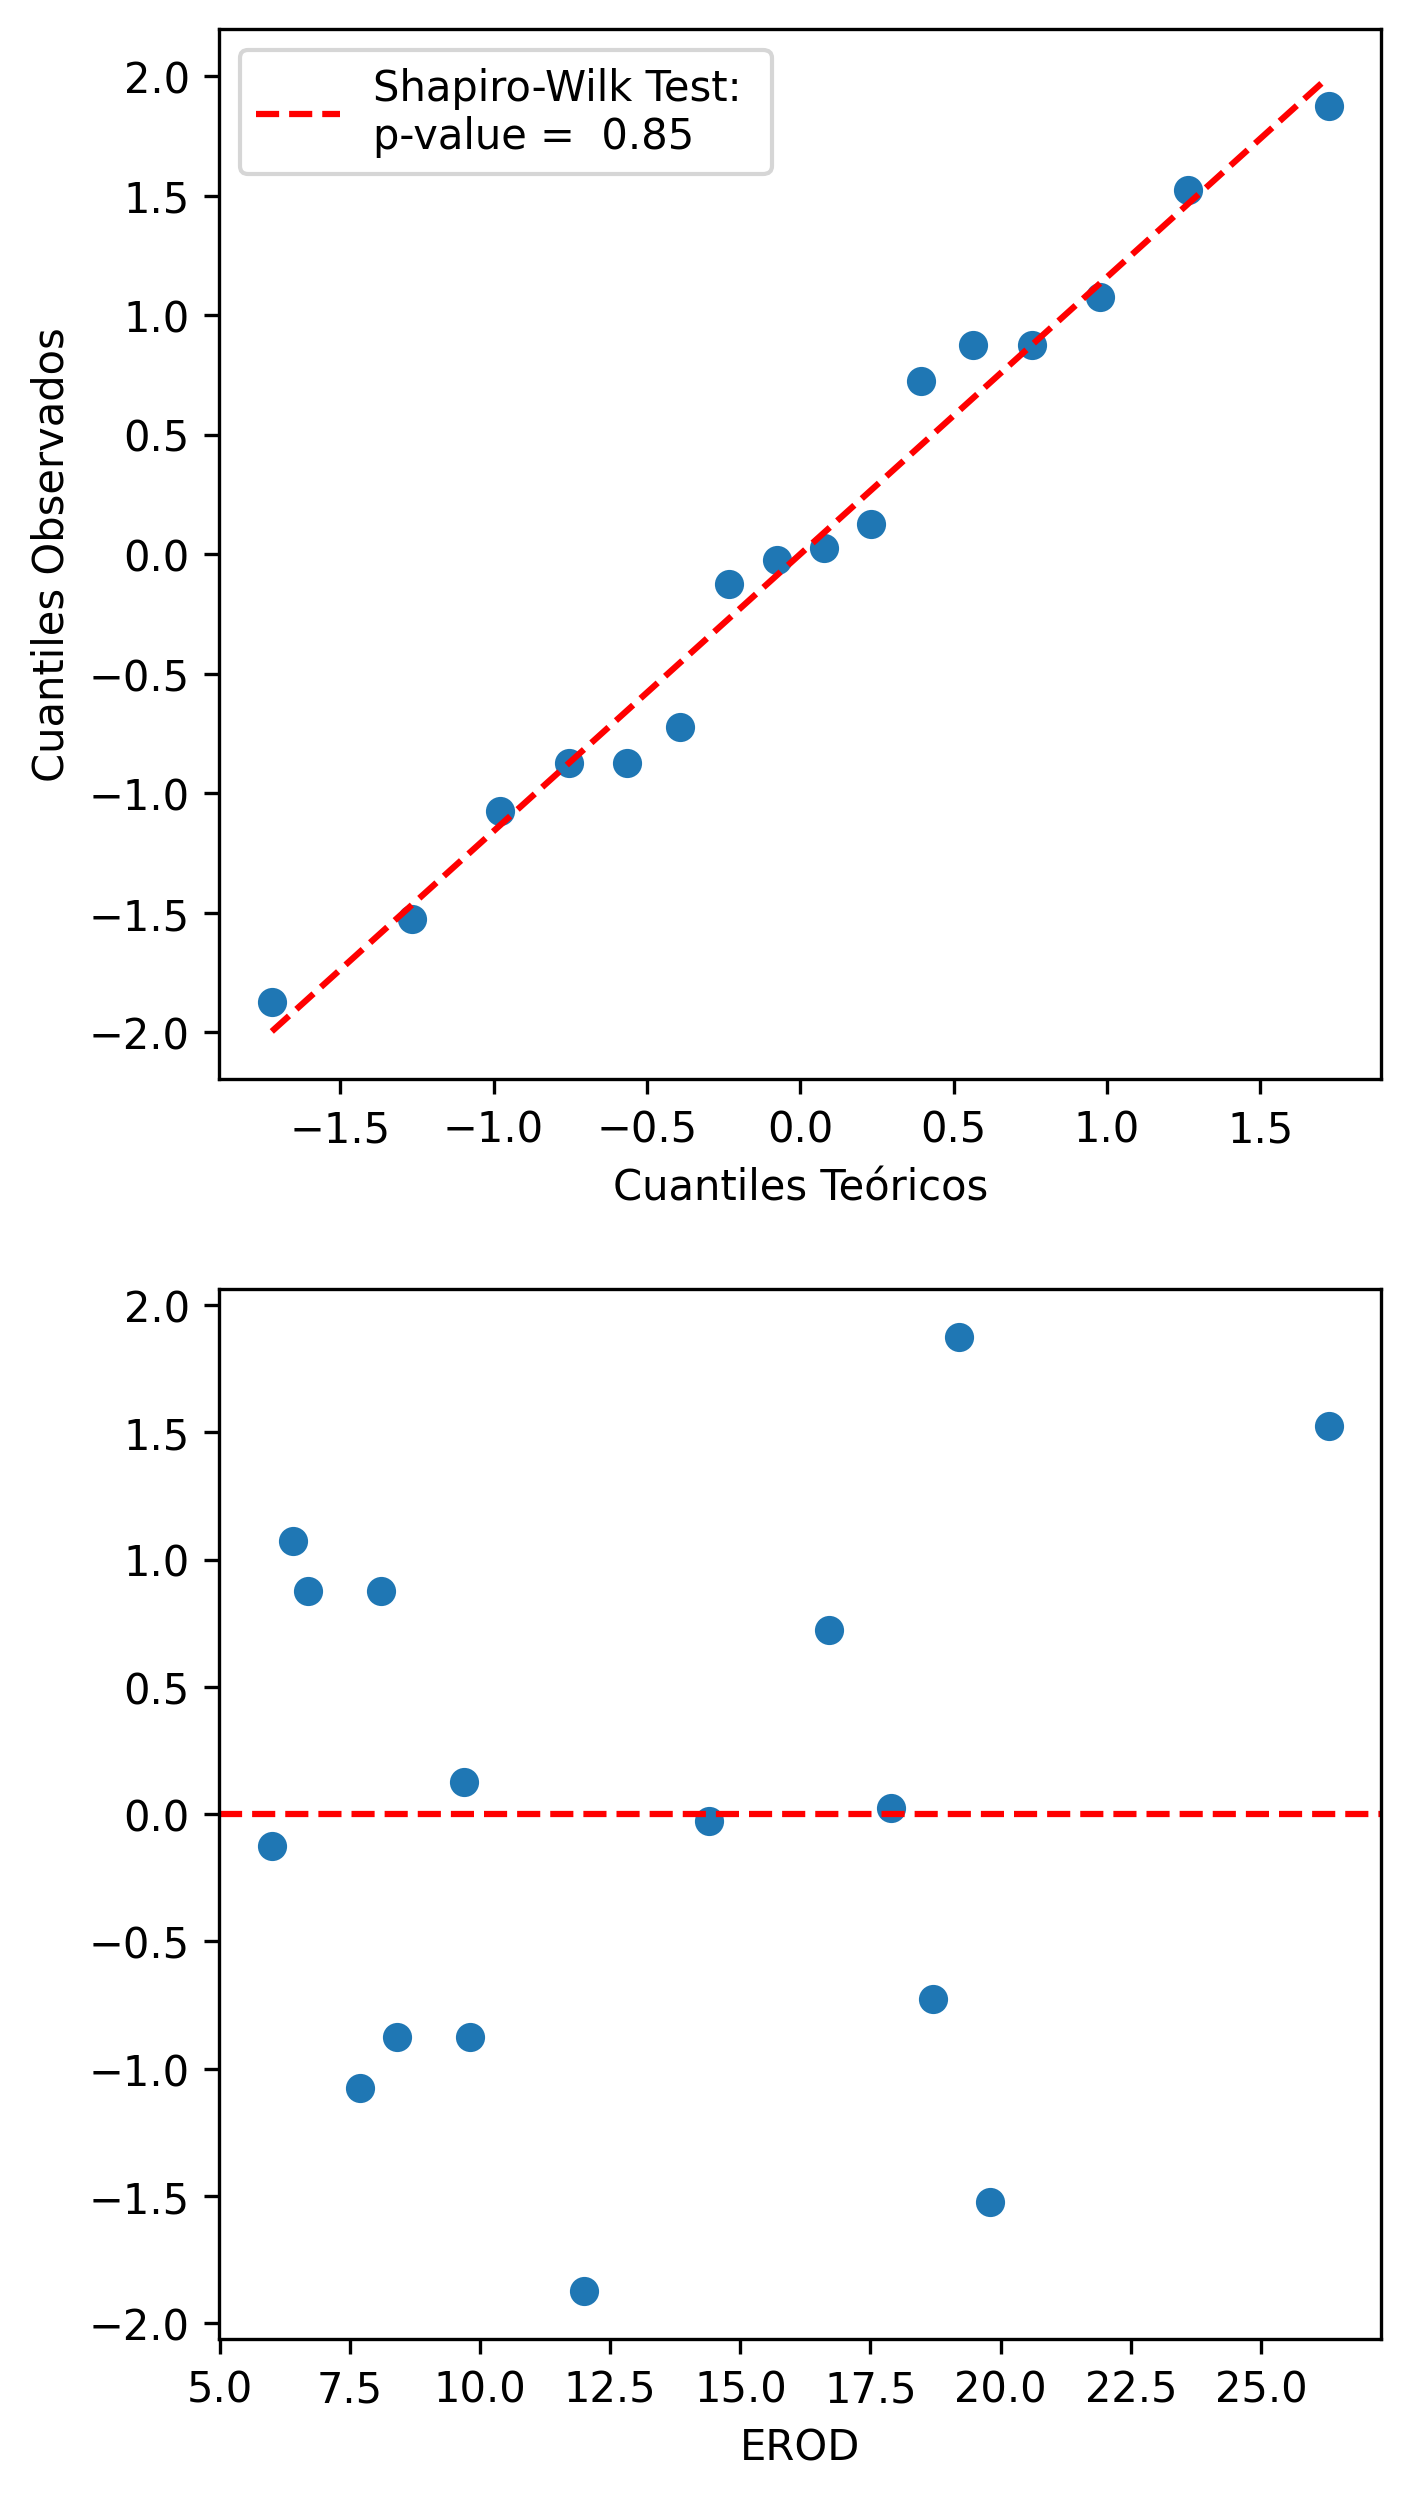

Shapiro-Wilk test de residuos
Shapiro-Wilk Test: 0.8478


In [194]:
# analisis de residuos

resid_bloq = model_bha_bloq.resid

resid_df = df_bha.copy()
resid_df['resid'] = resid_bloq

fig, ax = plt.subplots(2,1, figsize = (5,10), dpi = 300)
(osm, osr) , (slope, intercept, r_val) = st.probplot(resid_bloq, fit = True)
shapiro_p = st.shapiro(resid_bloq).pvalue
ax[0].scatter(osm, osr)
ax[0].plot(osm, osm*slope + intercept, color = 'r', linestyle = '--',
             label = f'Shapiro-Wilk Test: \np-value = {shapiro_p : .2f}')
ax[0].set_xlabel('Cuantiles Teóricos')
ax[0].set_ylabel('Cuantiles Observados')
ax[0].legend()

ax[1].scatter(resid_df['EROD'], resid_df['resid'])
ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('EROD')


plt.show()

print('Shapiro-Wilk test de residuos')
print(f'Shapiro-Wilk Test: {st.shapiro(model_bha_bloq.resid).pvalue:.4f}')
